In [1]:
!pip install tsai optuna  optuna-integration -q
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:32

In [2]:
from pandas import read_pickle
import numpy as np
import matplotlib.pyplot as plt
import notebookcfa27bdb31 as ArrayGenerator
from tsai.all import *
from fastai.callback.all import *
from optuna import create_study
from optuna.pruners import HyperbandPruner
from optuna.importance import get_param_importances
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.integration import FastAIPruningCallback
from random import seed
from gc import collect

* To get consistent results

In [3]:
torch.manual_seed(37)  # tsai is built on it so this should work..... I think?
seed(37)
np.random.seed(37)

In [4]:
df = read_pickle(
    "/kaggle/input/vhr-graduation-project-all/vhr_graduation_project_all.pickle"
)

In [5]:
X = np.array(df["ts"].to_list())
y = np.array(df["standardized_faults"])

In [6]:
# changed split method to split by bearing
raw_X, raw_y = ArrayGenerator.generate_dataset_array(
    dataset_category=2, ts=X, labels=y, split_method="bearing"
)

{'Faults classified': 'BearingFault, BearingWear, BearingLubrication', 'Channels taken': 'According to label', 'Labels array': 'Binary'}


In [7]:
def ts_without_NaN(ts):
    new_ts = []
    for value in ts:
        if not np.isnan(value):
            new_ts.append(value)
    return new_ts

In [8]:
# Padding function
def pad(array_3d):
    max_length = max(len(sub_arr) for arr in array_3d for sub_arr in arr)
    padded_array_3d = [
        [
            np.pad(sub_arr, (0, max_length - len(sub_arr)), mode="constant")
            for sub_arr in arr
        ]
        for arr in array_3d
    ]
    return np.array(padded_array_3d)

In [9]:
# Purging NaN values from our data to get its FFT
x_nonan = []
for bearing in raw_X:
    x_nonan.append(bearing[:, ~np.any(np.isnan(bearing), axis=0)])

* for training on raw timeseries without windowing

In [10]:
x_nonan_padded = pad(x_nonan)

In [11]:
#  applying earlystopping to get the best results and to prevent overfitting
callbacks = [
    PredictionDynamics(),
    EarlyStoppingCallback(monitor="f1_score", comp=np.greater, patience=3),
    SaveModelCallback(monitor="f1_score", comp=np.greater),
]

In [12]:
tfms = [None, [TSStandardize(by_var=False), Categorize()]]
batch_tfms = [TSStandardize(by_var=False)]

In [13]:
report_splits = get_splits(raw_y, valid_size=0.2, shuffle=True, show_plot=False)
X_train1, y_train1 = raw_X[report_splits[0]], raw_y[report_splits[0]]
X_test1, y_test1 = raw_X[report_splits[1]], raw_y[report_splits[1]]

In [14]:
torch.cuda.empty_cache()

In [15]:
def objective(trial):
    bs = trial.suggest_int("bs", 16, 40)  # suggest batch size
    apply_sliding_window = trial.suggest_categorical(
        "apply_sliding_window", [0, 1]
    )  # suggest whether to apply sliding window or not
    lr = trial.suggest_float("lr", 1e-7, 1e-1)  # suggest learning rate
    if apply_sliding_window:
        overlap_pct = trial.suggest_float(
            "overlap_pct", 0.0, 1.0
        )  # suggest overlap pct
        with_fft = trial.suggest_categorical(
            "with_fft", [0, 1]
        )  # suggest whether to apply FFT or not

        if overlap_pct > 0.5:  # to avoid an error in ArrayGenerator

            window_size1 = trial.suggest_categorical(
                "window_size1", [2048, 4096]
            )  # suggest window size # to avoid CategoricalDistribution does not support dynamic value space error
            X_train, y_train = ArrayGenerator.apply_sliding_window(
                X_train1,
                y_train1,
                window_size=window_size1,
                with_fft=with_fft,
                overlap_pct=overlap_pct,
            )
            X_test, y_test = ArrayGenerator.apply_sliding_window(
                X_test1,
                y_test1,
                window_size=window_size1,
                with_fft=with_fft,
                overlap_pct=0,
            )

        elif overlap_pct > 0.25:
            window_size2 = trial.suggest_categorical(
                "window_size2", [2048, 4096, 8192]
            )  # suggest window size
            X_train, y_train = ArrayGenerator.apply_sliding_window(
                X_train1,
                y_train1,
                window_size=window_size2,
                with_fft=with_fft,
                overlap_pct=overlap_pct,
            )
            X_test, y_test = ArrayGenerator.apply_sliding_window(
                X_test1,
                y_test1,
                window_size=window_size2,
                with_fft=with_fft,
                overlap_pct=0,
            )
        else:
            window_size3 = trial.suggest_categorical(
                "window_size3", [2048, 4096, 8192, 16384]
            )  # suggest window size
            X_train, y_train = ArrayGenerator.apply_sliding_window(
                X_train1,
                y_train1,
                window_size=window_size3,
                with_fft=with_fft,
                overlap_pct=overlap_pct,
            )
            X_test, y_test = ArrayGenerator.apply_sliding_window(
                X_test1,
                y_test1,
                window_size=window_size3,
                with_fft=with_fft,
                overlap_pct=0,
            )
        train_balance_splits = get_splits(
            y_train,
            valid_size=0,
            balance=True,
            strategy="oversample",
            shuffle=True,
            show_plot=False,
        )
        X_train, y_train = (
            X_train[train_balance_splits[0]],
            y_train[train_balance_splits[0]],
        )
        X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
        dls = get_ts_dls(
            X,
            y,
            splits=splits,
            tfms=tfms,
            shuffle_train=True,
            batch_tfms=batch_tfms,
            bs=[bs, 256],
        )

    else:

        dls = get_ts_dls(
            x_nonan_padded,
            raw_y,
            splits=report_splits,
            tfms=tfms,
            shuffle_train=True,
            batch_tfms=batch_tfms,
            bs=[bs, 256],
        )
    model = xresnet1d18(dls.vars, dls.c)

    learn = Learner(
        dls,
        model,
        lr=lr,
        metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()],
    )
    #  applying earlystopping to get the best results and to prevent overfitting
    callbacks = [
        PredictionDynamics(),
        EarlyStoppingCallback(monitor="f1_score", comp=np.greater, patience=3),
        SaveModelCallback(monitor="f1_score", comp=np.greater),
        FastAIPruningCallback(trial),
    ]
    with learn.no_logging(), learn.no_bar():
        learn.fit_one_cycle(15, cbs=callbacks.append(FastAIPruningCallback(trial)))
    f1 = learn.validate()[-2]
    model = None
    dls = None
    del learn  # to free memory
    collect()
    torch.cuda.empty_cache()
    return f1  # return F1 score

# optimizing 

In [16]:
study = create_study(direction="maximize", pruner=HyperbandPruner())
study.optimize(objective, n_trials=100)

[I 2024-04-23 01:51:25,009] A new study created in memory with name: no-name-e8866e49-fe35-4d36-8929-dcbfd542fb06


valid == train


[I 2024-04-23 01:52:30,316] Trial 0 finished with value: 0.6562054208273894 and parameters: {'bs': 35, 'apply_sliding_window': 1, 'lr': 0.075603058954359, 'overlap_pct': 0.3333354424110292, 'with_fft': 1, 'window_size2': 2048}. Best is trial 0 with value: 0.6562054208273894.


valid == train


[I 2024-04-23 01:53:15,823] Trial 1 finished with value: 0.6666666666666667 and parameters: {'bs': 29, 'apply_sliding_window': 1, 'lr': 0.07692805833885312, 'overlap_pct': 0.17337472261225606, 'with_fft': 0, 'window_size3': 4096}. Best is trial 1 with value: 0.6666666666666667.


valid == train


[I 2024-04-23 01:53:53,052] Trial 2 finished with value: 0.6792452830188679 and parameters: {'bs': 34, 'apply_sliding_window': 1, 'lr': 0.08277148622711154, 'overlap_pct': 0.3165123935063524, 'with_fft': 1, 'window_size2': 4096}. Best is trial 2 with value: 0.6792452830188679.


[I 2024-04-23 01:54:39,973] Trial 3 finished with value: 0.583941605839416 and parameters: {'bs': 38, 'apply_sliding_window': 0, 'lr': 0.03516716965132721}. Best is trial 2 with value: 0.6792452830188679.


[I 2024-04-23 01:55:26,775] Trial 4 finished with value: 0.46616541353383456 and parameters: {'bs': 18, 'apply_sliding_window': 0, 'lr': 0.05359346583306381}. Best is trial 2 with value: 0.6792452830188679.


valid == train


[I 2024-04-23 01:59:29,444] Trial 5 finished with value: 0.6612021857923497 and parameters: {'bs': 30, 'apply_sliding_window': 1, 'lr': 0.03749809053359509, 'overlap_pct': 0.911233309735209, 'with_fft': 1, 'window_size1': 4096}. Best is trial 2 with value: 0.6792452830188679.


valid == train


[I 2024-04-23 02:00:57,984] Trial 6 finished with value: 0.6638537271448665 and parameters: {'bs': 24, 'apply_sliding_window': 1, 'lr': 0.0843330030807992, 'overlap_pct': 0.34614473123862044, 'with_fft': 1, 'window_size2': 2048}. Best is trial 2 with value: 0.6792452830188679.


[I 2024-04-23 02:01:44,686] Trial 7 finished with value: 0.625 and parameters: {'bs': 38, 'apply_sliding_window': 0, 'lr': 0.009605339209402264}. Best is trial 2 with value: 0.6792452830188679.


[I 2024-04-23 02:02:28,033] Trial 8 finished with value: 0.5657894736842105 and parameters: {'bs': 28, 'apply_sliding_window': 0, 'lr': 0.060014249003653986}. Best is trial 2 with value: 0.6792452830188679.


[I 2024-04-23 02:03:13,913] Trial 9 finished with value: 0.5352112676056339 and parameters: {'bs': 37, 'apply_sliding_window': 0, 'lr': 0.09371396992947413}. Best is trial 2 with value: 0.6792452830188679.


valid == train


[I 2024-04-23 02:06:23,105] Trial 10 finished with value: 0.6726572528883183 and parameters: {'bs': 32, 'apply_sliding_window': 1, 'lr': 0.06592876864367973, 'overlap_pct': 0.7204017887320455, 'with_fft': 0, 'window_size1': 2048}. Best is trial 2 with value: 0.6792452830188679.


valid == train


[I 2024-04-23 02:09:10,713] Trial 11 finished with value: 0.6818181818181818 and parameters: {'bs': 32, 'apply_sliding_window': 1, 'lr': 0.0658018191863622, 'overlap_pct': 0.6760181693891428, 'with_fft': 0, 'window_size1': 2048}. Best is trial 11 with value: 0.6818181818181818.


valid == train


[I 2024-04-23 02:11:51,523] Trial 12 finished with value: 0.6376440460947504 and parameters: {'bs': 24, 'apply_sliding_window': 1, 'lr': 0.09897682411747397, 'overlap_pct': 0.592318799220333, 'with_fft': 0, 'window_size1': 2048}. Best is trial 11 with value: 0.6818181818181818.


valid == train


[I 2024-04-23 02:12:56,821] Trial 13 finished with value: 0.6536458333333334 and parameters: {'bs': 33, 'apply_sliding_window': 1, 'lr': 0.04142232835968153, 'overlap_pct': 0.03033892924906645, 'with_fft': 0, 'window_size3': 2048}. Best is trial 11 with value: 0.6818181818181818.


valid == train


[I 2024-04-23 02:14:13,849] Trial 14 finished with value: 0.6587537091988129 and parameters: {'bs': 40, 'apply_sliding_window': 1, 'lr': 0.06722709364116267, 'overlap_pct': 0.5273334067549981, 'with_fft': 1, 'window_size1': 2048}. Best is trial 11 with value: 0.6818181818181818.


valid == train


[I 2024-04-23 02:16:04,822] Trial 15 finished with value: 0.6778711484593837 and parameters: {'bs': 25, 'apply_sliding_window': 1, 'lr': 0.023812713951932293, 'overlap_pct': 0.7773984322043412, 'with_fft': 1, 'window_size1': 4096}. Best is trial 11 with value: 0.6818181818181818.


valid == train


[I 2024-04-23 02:16:51,018] Trial 16 finished with value: 0.7180851063829787 and parameters: {'bs': 34, 'apply_sliding_window': 1, 'lr': 0.08578478937680406, 'overlap_pct': 0.38437995522822455, 'with_fft': 0, 'window_size2': 4096}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 02:20:16,156] Trial 17 finished with value: 0.6792963464140731 and parameters: {'bs': 20, 'apply_sliding_window': 1, 'lr': 0.05121675536444628, 'overlap_pct': 0.6555027066683646, 'with_fft': 0, 'window_size1': 2048}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 02:36:41,852] Trial 18 finished with value: 0.6600284495021337 and parameters: {'bs': 30, 'apply_sliding_window': 1, 'lr': 0.08800936884475545, 'overlap_pct': 0.9458853323652298, 'with_fft': 0, 'window_size1': 2048}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 02:37:19,059] Trial 19 finished with value: 0.6445497630331753 and parameters: {'bs': 36, 'apply_sliding_window': 1, 'lr': 0.0664535565761196, 'overlap_pct': 0.4373631195136507, 'with_fft': 0, 'window_size2': 8192}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 02:39:43,297] Trial 20 finished with value: 0.6809651474530831 and parameters: {'bs': 27, 'apply_sliding_window': 1, 'lr': 0.07426557872525627, 'overlap_pct': 0.8177168551260161, 'with_fft': 0, 'window_size1': 4096}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 02:42:03,802] Trial 21 finished with value: 0.6343825665859564 and parameters: {'bs': 27, 'apply_sliding_window': 1, 'lr': 0.0753590069058925, 'overlap_pct': 0.8084557832818436, 'with_fft': 0, 'window_size1': 4096}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 02:44:26,952] Trial 22 finished with value: 0.625 and parameters: {'bs': 32, 'apply_sliding_window': 1, 'lr': 0.0591730124188959, 'overlap_pct': 0.8212834910251104, 'with_fft': 0, 'window_size1': 4096}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 02:45:57,078] Trial 23 finished with value: 0.6764705882352942 and parameters: {'bs': 21, 'apply_sliding_window': 1, 'lr': 0.09110301304395402, 'overlap_pct': 0.6176362157788898, 'with_fft': 0, 'window_size1': 4096}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 02:46:49,539] Trial 24 finished with value: 0.6745843230403801 and parameters: {'bs': 26, 'apply_sliding_window': 1, 'lr': 0.07436027401980129, 'overlap_pct': 0.481940921501542, 'with_fft': 0, 'window_size2': 4096}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 02:49:41,668] Trial 25 finished with value: 0.6911957950065702 and parameters: {'bs': 31, 'apply_sliding_window': 1, 'lr': 0.09948780143382013, 'overlap_pct': 0.6843758714346282, 'with_fft': 0, 'window_size1': 2048}. Best is trial 16 with value: 0.7180851063829787.


[I 2024-04-23 02:50:27,857] Trial 26 finished with value: 0.5342465753424658 and parameters: {'bs': 31, 'apply_sliding_window': 0, 'lr': 0.09237109397072406}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 02:51:18,150] Trial 27 finished with value: 0.6798029556650247 and parameters: {'bs': 34, 'apply_sliding_window': 1, 'lr': 0.09953978062812903, 'overlap_pct': 0.42327699155169224, 'with_fft': 0, 'window_size2': 4096}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 02:53:46,931] Trial 28 finished with value: 0.6454183266932271 and parameters: {'bs': 40, 'apply_sliding_window': 1, 'lr': 0.08309307474448163, 'overlap_pct': 0.6749461926968818, 'with_fft': 0, 'window_size1': 2048}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 02:55:40,362] Trial 29 finished with value: 0.6851119894598156 and parameters: {'bs': 35, 'apply_sliding_window': 1, 'lr': 0.07963782247038748, 'overlap_pct': 0.5499489347683963, 'with_fft': 0, 'window_size1': 2048}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 02:57:33,997] Trial 30 finished with value: 0.6808510638297873 and parameters: {'bs': 35, 'apply_sliding_window': 1, 'lr': 0.09891823554761134, 'overlap_pct': 0.5474188602594967, 'with_fft': 0, 'window_size1': 2048}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 02:58:11,754] Trial 31 finished with value: 0.6176470588235294 and parameters: {'bs': 35, 'apply_sliding_window': 1, 'lr': 0.08212459972558919, 'overlap_pct': 0.2382487237629698, 'with_fft': 0, 'window_size3': 8192}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 03:01:17,080] Trial 32 finished with value: 0.6264044943820225 and parameters: {'bs': 32, 'apply_sliding_window': 1, 'lr': 0.06938310248962155, 'overlap_pct': 0.717242079246752, 'with_fft': 0, 'window_size1': 2048}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 03:03:26,795] Trial 33 finished with value: 0.6620111731843575 and parameters: {'bs': 29, 'apply_sliding_window': 1, 'lr': 0.08647174886831308, 'overlap_pct': 0.5701184365238947, 'with_fft': 0, 'window_size1': 2048}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 03:04:05,117] Trial 34 finished with value: 0.6604651162790697 and parameters: {'bs': 34, 'apply_sliding_window': 1, 'lr': 0.06086161634039591, 'overlap_pct': 0.4575515925404091, 'with_fft': 0, 'window_size2': 8192}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 03:04:50,845] Trial 35 finished with value: 0.6956521739130435 and parameters: {'bs': 37, 'apply_sliding_window': 1, 'lr': 0.0791012594783114, 'overlap_pct': 0.39863714573363085, 'with_fft': 0, 'window_size2': 4096}. Best is trial 16 with value: 0.7180851063829787.


[I 2024-04-23 03:05:37,464] Trial 36 finished with value: 0.5857142857142857 and parameters: {'bs': 38, 'apply_sliding_window': 0, 'lr': 0.07993916331479498}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 03:06:22,919] Trial 37 finished with value: 0.662004662004662 and parameters: {'bs': 36, 'apply_sliding_window': 1, 'lr': 0.09349283538280041, 'overlap_pct': 0.35701187106748855, 'with_fft': 0, 'window_size2': 4096}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 03:07:08,700] Trial 38 finished with value: 0.6666666666666667 and parameters: {'bs': 37, 'apply_sliding_window': 1, 'lr': 0.07814468689933349, 'overlap_pct': 0.2603151867313277, 'with_fft': 0, 'window_size2': 4096}. Best is trial 16 with value: 0.7180851063829787.


[I 2024-04-23 03:07:53,699] Trial 39 finished with value: 0.028169014084507043 and parameters: {'bs': 39, 'apply_sliding_window': 0, 'lr': 0.08851350535500904}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 03:09:02,152] Trial 40 finished with value: 0.6844660194174756 and parameters: {'bs': 16, 'apply_sliding_window': 1, 'lr': 0.07148646368087866, 'overlap_pct': 0.39222262059259183, 'with_fft': 0, 'window_size2': 4096}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 03:09:51,557] Trial 41 finished with value: 0.6777251184834123 and parameters: {'bs': 36, 'apply_sliding_window': 1, 'lr': 0.07221433434133437, 'overlap_pct': 0.41913412730225513, 'with_fft': 0, 'window_size2': 4096}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 03:10:06,595] Trial 42 finished with value: 0.7142857142857143 and parameters: {'bs': 30, 'apply_sliding_window': 1, 'lr': 0.0795652106724081, 'overlap_pct': 0.1656325724743546, 'with_fft': 0, 'window_size3': 16384}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 03:10:21,608] Trial 43 finished with value: 0.6976744186046512 and parameters: {'bs': 30, 'apply_sliding_window': 1, 'lr': 0.08022400561422344, 'overlap_pct': 0.11168603351995565, 'with_fft': 0, 'window_size3': 16384}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 03:10:30,433] Trial 44 finished with value: 0.6451612903225806 and parameters: {'bs': 30, 'apply_sliding_window': 1, 'lr': 0.09443082780554504, 'overlap_pct': 0.10360401817121997, 'with_fft': 1, 'window_size3': 16384}. Best is trial 16 with value: 0.7180851063829787.


[I 2024-04-23 03:11:16,429] Trial 45 finished with value: 0.56 and parameters: {'bs': 29, 'apply_sliding_window': 0, 'lr': 0.08505909054682984}. Best is trial 16 with value: 0.7180851063829787.


valid == train


[I 2024-04-23 03:11:30,966] Trial 46 finished with value: 0.7272727272727272 and parameters: {'bs': 33, 'apply_sliding_window': 1, 'lr': 0.023355345143483752, 'overlap_pct': 0.19844295629421405, 'with_fft': 0, 'window_size3': 16384}. Best is trial 46 with value: 0.7272727272727272.


valid == train


[I 2024-04-23 03:11:39,480] Trial 47 finished with value: 0.625 and parameters: {'bs': 33, 'apply_sliding_window': 1, 'lr': 0.0032299821132890927, 'overlap_pct': 0.15167614238488036, 'with_fft': 1, 'window_size3': 16384}. Best is trial 46 with value: 0.7272727272727272.


valid == train


[I 2024-04-23 03:12:25,922] Trial 48 finished with value: 0.6401869158878505 and parameters: {'bs': 33, 'apply_sliding_window': 1, 'lr': 0.026855455150352568, 'overlap_pct': 0.2695381999926726, 'with_fft': 0, 'window_size2': 4096}. Best is trial 46 with value: 0.7272727272727272.


valid == train


[I 2024-04-23 03:12:39,242] Trial 49 finished with value: 0.7096774193548386 and parameters: {'bs': 28, 'apply_sliding_window': 1, 'lr': 0.028951399170814424, 'overlap_pct': 0.059294804022908876, 'with_fft': 0, 'window_size3': 16384}. Best is trial 46 with value: 0.7272727272727272.


[I 2024-04-23 03:13:22,436] Trial 50 finished with value: 0.6111111111111113 and parameters: {'bs': 28, 'apply_sliding_window': 0, 'lr': 0.017391715996331332}. Best is trial 46 with value: 0.7272727272727272.


valid == train


[I 2024-04-23 03:13:35,885] Trial 51 finished with value: 0.7272727272727272 and parameters: {'bs': 31, 'apply_sliding_window': 1, 'lr': 0.046335159822531655, 'overlap_pct': 0.009856261199562066, 'with_fft': 0, 'window_size3': 16384}. Best is trial 46 with value: 0.7272727272727272.


valid == train


[I 2024-04-23 03:13:50,576] Trial 52 finished with value: 0.7428571428571429 and parameters: {'bs': 29, 'apply_sliding_window': 1, 'lr': 0.040097121198732266, 'overlap_pct': 0.006432921621584889, 'with_fft': 0, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:14:03,933] Trial 53 finished with value: 0.7000000000000001 and parameters: {'bs': 28, 'apply_sliding_window': 1, 'lr': 0.045071071638556504, 'overlap_pct': 0.032716029995923504, 'with_fft': 0, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:14:17,369] Trial 54 finished with value: 0.7428571428571429 and parameters: {'bs': 31, 'apply_sliding_window': 1, 'lr': 0.03363696916427476, 'overlap_pct': 0.01751162120024871, 'with_fft': 0, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:14:25,323] Trial 55 finished with value: 0.7027027027027029 and parameters: {'bs': 31, 'apply_sliding_window': 1, 'lr': 0.035242711747936896, 'overlap_pct': 0.004900055388069629, 'with_fft': 1, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:14:39,855] Trial 56 finished with value: 0.611111111111111 and parameters: {'bs': 33, 'apply_sliding_window': 1, 'lr': 0.04507659066002227, 'overlap_pct': 0.1938014036429745, 'with_fft': 0, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:14:54,845] Trial 57 finished with value: 0.7368421052631579 and parameters: {'bs': 30, 'apply_sliding_window': 1, 'lr': 0.03973837898152438, 'overlap_pct': 0.08633258730024045, 'with_fft': 0, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:15:09,189] Trial 58 finished with value: 0.7222222222222222 and parameters: {'bs': 26, 'apply_sliding_window': 1, 'lr': 0.03922599606369959, 'overlap_pct': 0.08251772601375923, 'with_fft': 0, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:15:18,467] Trial 59 finished with value: 0.7407407407407408 and parameters: {'bs': 24, 'apply_sliding_window': 1, 'lr': 0.038980046094868194, 'overlap_pct': 0.11639337985761716, 'with_fft': 1, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:15:27,484] Trial 60 finished with value: 0.6666666666666665 and parameters: {'bs': 23, 'apply_sliding_window': 1, 'lr': 0.031616853026208556, 'overlap_pct': 0.0007664025126517815, 'with_fft': 1, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:15:36,160] Trial 61 finished with value: 0.7272727272727272 and parameters: {'bs': 25, 'apply_sliding_window': 1, 'lr': 0.04073238113900934, 'overlap_pct': 0.08247340976206383, 'with_fft': 1, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:15:45,188] Trial 62 finished with value: 0.7142857142857142 and parameters: {'bs': 23, 'apply_sliding_window': 1, 'lr': 0.021696355549400533, 'overlap_pct': 0.13560593872665308, 'with_fft': 1, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:15:53,798] Trial 63 finished with value: 0.606060606060606 and parameters: {'bs': 25, 'apply_sliding_window': 1, 'lr': 0.044038590252521846, 'overlap_pct': 0.059892381848315586, 'with_fft': 1, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:16:03,109] Trial 64 finished with value: 0.6666666666666666 and parameters: {'bs': 21, 'apply_sliding_window': 1, 'lr': 0.04813235759997735, 'overlap_pct': 0.2023831524043032, 'with_fft': 1, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:16:12,040] Trial 65 finished with value: 0.5714285714285715 and parameters: {'bs': 27, 'apply_sliding_window': 1, 'lr': 0.03321261824727612, 'overlap_pct': 0.05179845977558576, 'with_fft': 1, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:17:08,786] Trial 66 finished with value: 0.6666666666666666 and parameters: {'bs': 29, 'apply_sliding_window': 1, 'lr': 0.0544825252143696, 'overlap_pct': 0.10649464376872228, 'with_fft': 1, 'window_size3': 2048}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:17:36,802] Trial 67 finished with value: 0.5894736842105263 and parameters: {'bs': 23, 'apply_sliding_window': 1, 'lr': 0.038623438000175224, 'overlap_pct': 0.08198320050227692, 'with_fft': 1, 'window_size3': 8192}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:18:15,906] Trial 68 finished with value: 0.6648793565683646 and parameters: {'bs': 25, 'apply_sliding_window': 1, 'lr': 0.041134875083079316, 'overlap_pct': 0.022680290793286977, 'with_fft': 1, 'window_size3': 4096}. Best is trial 52 with value: 0.7428571428571429.


[I 2024-04-23 03:19:02,109] Trial 69 finished with value: 0.6338028169014084 and parameters: {'bs': 31, 'apply_sliding_window': 0, 'lr': 0.01702240878741395}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:19:10,929] Trial 70 finished with value: 0.7058823529411765 and parameters: {'bs': 26, 'apply_sliding_window': 1, 'lr': 0.035994110219753565, 'overlap_pct': 0.12554078347098838, 'with_fft': 1, 'window_size3': 16384}. Best is trial 52 with value: 0.7428571428571429.


valid == train


[I 2024-04-23 03:19:26,137] Trial 71 finished with value: 0.8125 and parameters: {'bs': 24, 'apply_sliding_window': 1, 'lr': 0.04025226717705752, 'overlap_pct': 0.07430532183482412, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:19:41,373] Trial 72 finished with value: 0.7027027027027029 and parameters: {'bs': 24, 'apply_sliding_window': 1, 'lr': 0.047596716917751025, 'overlap_pct': 0.05720355653075882, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:19:55,679] Trial 73 finished with value: 0.7027027027027029 and parameters: {'bs': 22, 'apply_sliding_window': 1, 'lr': 0.05529193206320216, 'overlap_pct': 0.18734423083848956, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:20:10,560] Trial 74 finished with value: 0.7647058823529413 and parameters: {'bs': 19, 'apply_sliding_window': 1, 'lr': 0.0506503305646077, 'overlap_pct': 0.08995369239340728, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:20:26,030] Trial 75 finished with value: 0.7647058823529413 and parameters: {'bs': 16, 'apply_sliding_window': 1, 'lr': 0.0526938946988388, 'overlap_pct': 0.03286049467510534, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:20:41,317] Trial 76 finished with value: 0.6875 and parameters: {'bs': 18, 'apply_sliding_window': 1, 'lr': 0.051640027490545276, 'overlap_pct': 0.21838809423661815, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:21:43,401] Trial 77 finished with value: 0.6836027713625866 and parameters: {'bs': 16, 'apply_sliding_window': 1, 'lr': 0.05717325321793664, 'overlap_pct': 0.1637300778410809, 'with_fft': 0, 'window_size3': 4096}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:21:58,768] Trial 78 finished with value: 0.7272727272727272 and parameters: {'bs': 18, 'apply_sliding_window': 1, 'lr': 0.06204155393698531, 'overlap_pct': 0.03833434319157695, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:22:13,654] Trial 79 finished with value: 0.6875 and parameters: {'bs': 19, 'apply_sliding_window': 1, 'lr': 0.031066614296835597, 'overlap_pct': 0.12925087176757144, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:23:50,002] Trial 80 finished with value: 0.6804123711340205 and parameters: {'bs': 17, 'apply_sliding_window': 1, 'lr': 0.050222841502444646, 'overlap_pct': 0.09213830840962292, 'with_fft': 0, 'window_size3': 2048}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:24:04,084] Trial 81 finished with value: 0.7428571428571429 and parameters: {'bs': 20, 'apply_sliding_window': 1, 'lr': 0.04297466576356068, 'overlap_pct': 0.005676990884787847, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:24:45,299] Trial 82 finished with value: 0.6435643564356436 and parameters: {'bs': 19, 'apply_sliding_window': 1, 'lr': 0.02567360242209285, 'overlap_pct': 0.04162076671753934, 'with_fft': 0, 'window_size3': 8192}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:24:59,359] Trial 83 finished with value: 0.7368421052631579 and parameters: {'bs': 20, 'apply_sliding_window': 1, 'lr': 0.04279943530576231, 'overlap_pct': 0.0740811354396261, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:25:13,403] Trial 84 finished with value: 0.6842105263157895 and parameters: {'bs': 20, 'apply_sliding_window': 1, 'lr': 0.04242294354898789, 'overlap_pct': 0.0008762207848676262, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:25:27,899] Trial 85 finished with value: 0.7222222222222222 and parameters: {'bs': 21, 'apply_sliding_window': 1, 'lr': 0.036948703162034864, 'overlap_pct': 0.07186939744035079, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


[I 2024-04-23 03:26:13,209] Trial 86 finished with value: 0.5802469135802469 and parameters: {'bs': 20, 'apply_sliding_window': 0, 'lr': 0.05179788427109851}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:26:28,125] Trial 87 finished with value: 0.7741935483870969 and parameters: {'bs': 17, 'apply_sliding_window': 1, 'lr': 0.04277627637533716, 'overlap_pct': 0.034366453220712294, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:26:43,039] Trial 88 finished with value: 0.7096774193548386 and parameters: {'bs': 17, 'apply_sliding_window': 1, 'lr': 0.03328479318292642, 'overlap_pct': 0.030937674313965404, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:26:57,969] Trial 89 finished with value: 0.7333333333333333 and parameters: {'bs': 17, 'apply_sliding_window': 1, 'lr': 0.04799548354836612, 'overlap_pct': 0.15281745841295707, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:28:54,011] Trial 90 finished with value: 0.6820512820512821 and parameters: {'bs': 19, 'apply_sliding_window': 1, 'lr': 0.03931038049271558, 'overlap_pct': 0.3077667820166504, 'with_fft': 0, 'window_size2': 2048}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:29:09,480] Trial 91 finished with value: 0.7647058823529413 and parameters: {'bs': 16, 'apply_sliding_window': 1, 'lr': 0.04345237029821415, 'overlap_pct': 0.11217122005470753, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:29:24,890] Trial 92 finished with value: 0.7272727272727272 and parameters: {'bs': 16, 'apply_sliding_window': 1, 'lr': 0.0377406809079577, 'overlap_pct': 0.10422111867926137, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:29:40,220] Trial 93 finished with value: 0.7368421052631579 and parameters: {'bs': 18, 'apply_sliding_window': 1, 'lr': 0.04928371063084417, 'overlap_pct': 0.036569981055455336, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:29:55,182] Trial 94 finished with value: 0.7027027027027029 and parameters: {'bs': 17, 'apply_sliding_window': 1, 'lr': 0.043748162490468194, 'overlap_pct': 0.13060374212479361, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:30:10,583] Trial 95 finished with value: 0.7500000000000001 and parameters: {'bs': 16, 'apply_sliding_window': 1, 'lr': 0.04036800863412647, 'overlap_pct': 0.021319750068230604, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:31:12,966] Trial 96 finished with value: 0.6635730858468677 and parameters: {'bs': 16, 'apply_sliding_window': 1, 'lr': 0.04622314614809147, 'overlap_pct': 0.013505964311742287, 'with_fft': 0, 'window_size3': 4096}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:31:27,929] Trial 97 finished with value: 0.7647058823529413 and parameters: {'bs': 17, 'apply_sliding_window': 1, 'lr': 0.034368406840251275, 'overlap_pct': 0.05845982493502206, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


valid == train


[I 2024-04-23 03:31:42,850] Trial 98 finished with value: 0.7058823529411765 and parameters: {'bs': 17, 'apply_sliding_window': 1, 'lr': 0.03414060375429576, 'overlap_pct': 0.04883226704654407, 'with_fft': 0, 'window_size3': 16384}. Best is trial 71 with value: 0.8125.


[I 2024-04-23 03:32:31,457] Trial 99 finished with value: 0.5935483870967743 and parameters: {'bs': 16, 'apply_sliding_window': 0, 'lr': 0.06332231356710552}. Best is trial 71 with value: 0.8125.


# Results

In [17]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

get_param_importances(study)

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  0.8125
  Params: 
    bs: 24
    apply_sliding_window: 1
    lr: 0.04025226717705752
    overlap_pct: 0.07430532183482412
    with_fft: 0
    window_size3: 16384


{'apply_sliding_window': 0.5647794444904322,
 'bs': 0.34250862999764964,
 'lr': 0.09271192551191833}

In [18]:
plotly_config = {"staticPlot": True}
fig = plot_optimization_history(study)
fig.show(config=plotly_config)

In [19]:
fig = plot_param_importances(study)
fig.show(config=plotly_config)

# Training with the best found hyperparamters

valid == train


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,1.761454,2.725793,0.428571,0.428571,1.000000,0.600000,0.500000,00:04
1,1.469292,1.097762,0.428571,0.428571,1.000000,0.600000,0.500000,00:04
2,1.189989,0.682110,0.571429,0.000000,0.000000,0.000000,0.500000,00:04
3,1.005213,0.721705,0.428571,0.424242,0.933333,0.583333,0.491667,00:04


Better model found at epoch 0 with f1_score value: 0.6.


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score
2,1.189989,0.68211,0.571429,0.0,0.0,0.0,0.5


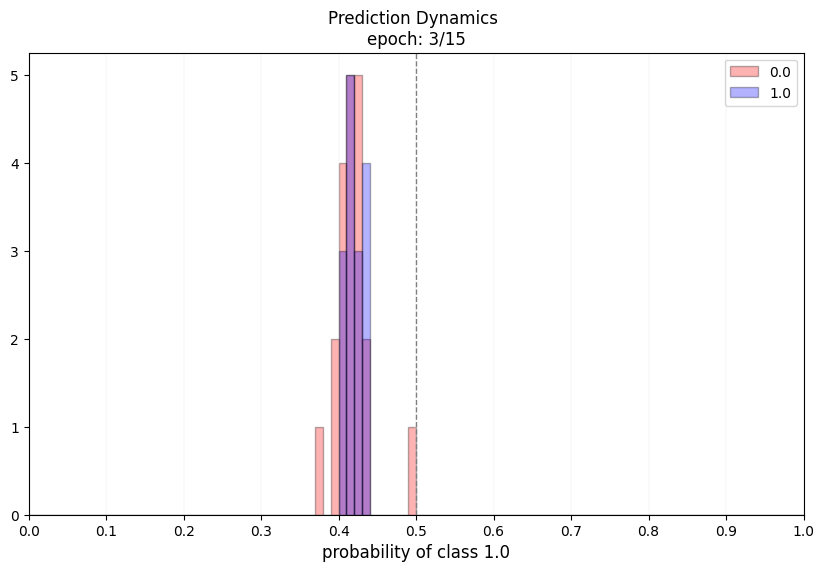

No improvement since epoch 0: early stopping


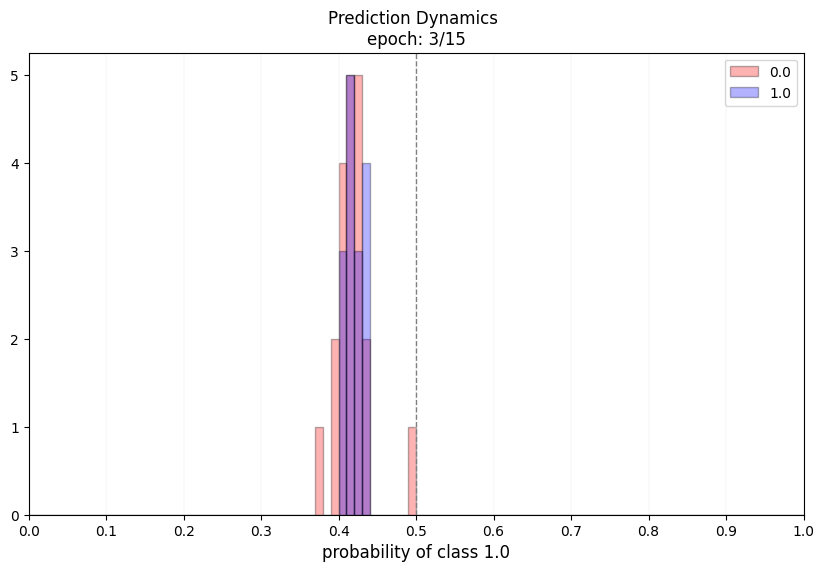

In [20]:
if apply_sliding_window:
    if trial.params["overlap_pct"] > 0.5:  # to avoid an error in ArrayGenerator
        X_train, y_train = ArrayGenerator.apply_sliding_window(
            X_train1,
            y_train1,
            window_size=trial.params["window_size1"],
            with_fft=trial.params["with_fft"],
            overlap_pct=trial.params["overlap_pct"],
        )
        X_test, y_test = ArrayGenerator.apply_sliding_window(
            X_test1,
            y_test1,
            window_size=trial.params["window_size1"],
            with_fft=trial.params["with_fft"],
            overlap_pct=0,
        )

    elif trial.params["overlap_pct"] > 0.25:
        X_train, y_train = ArrayGenerator.apply_sliding_window(
            X_train1,
            y_train1,
            window_size=trial.params["window_size2"],
            with_fft=trial.params["with_fft"],
            overlap_pct=trial.params["overlap_pct"],
        )
        X_test, y_test = ArrayGenerator.apply_sliding_window(
            X_test1,
            y_test1,
            window_size=trial.params["window_size2"],
            with_fft=trial.params["with_fft"],
            overlap_pct=0,
        )
    else:
        X_train, y_train = ArrayGenerator.apply_sliding_window(
            X_train1,
            y_train1,
            window_size=trial.params["window_size3"],
            with_fft=trial.params["with_fft"],
            overlap_pct=trial.params["overlap_pct"],
        )
        X_test, y_test = ArrayGenerator.apply_sliding_window(
            X_test1,
            y_test1,
            window_size=trial.params["window_size3"],
            with_fft=trial.params["with_fft"],
            overlap_pct=0,
        )
    train_balance_splits = get_splits(
        y_train,
        valid_size=0,
        balance=True,
        strategy="oversample",
        shuffle=True,
        show_plot=False,
    )
    X_train, y_train = (
        X_train[train_balance_splits[0]],
        y_train[train_balance_splits[0]],
    )
    X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
    dls = get_ts_dls(
        X,
        y,
        splits=splits,
        tfms=tfms,
        shuffle_train=True,
        batch_tfms=batch_tfms,
        bs=[trial.params["bs"], 256],
    )
else:
    dls = get_ts_dls(
        x_nonan_padded,
        raw_y,
        splits=report_splits,
        tfms=tfms,
        shuffle_train=True,
        batch_tfms=batch_tfms,
        bs=[trial.params["bs"], 256],
    )
model = xresnet1d50_deeper(dls.vars, dls.c)
learn = Learner(
    dls,
    model,
    lr=trial.params["lr"],
    metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()],
)

learn.fit_one_cycle(15, cbs=callbacks);

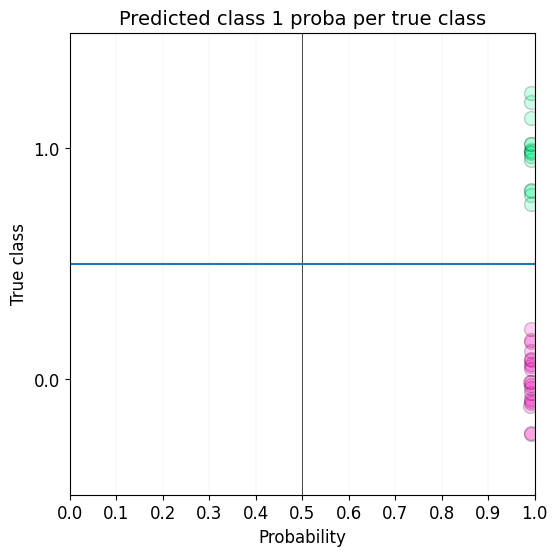

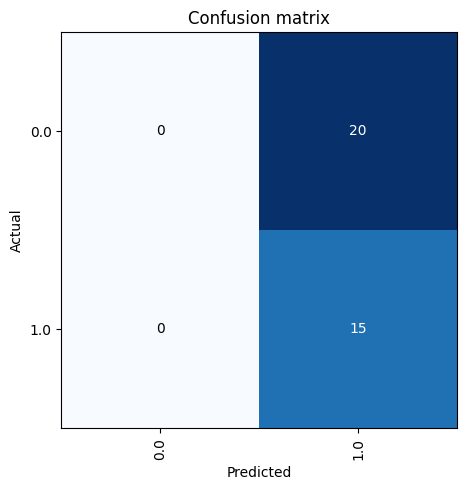

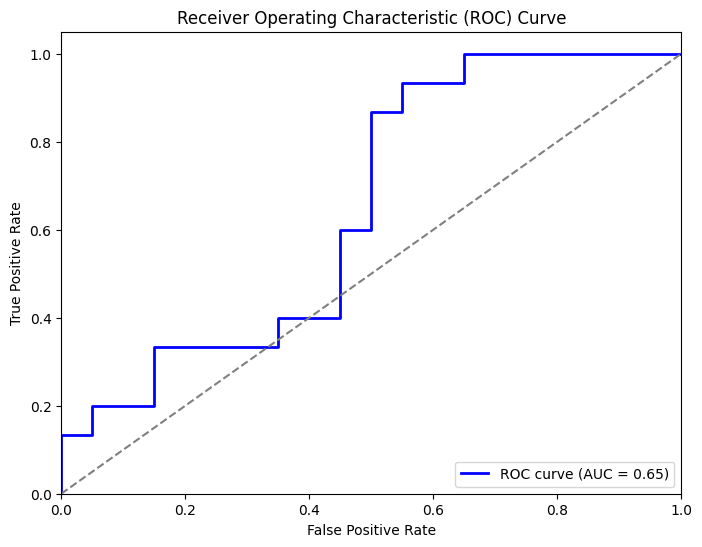

In [21]:
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(
    dl=valid_dl, with_decoded=True
)
from sklearn.metrics import roc_curve, auc

positive_probs = valid_probas[:, 1]
# Draw ROC curve to help us adjust the threshold to a better value.
fpr, tpr, thresholds = roc_curve(valid_targets, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()